In [230]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
VIS_HIGHLINE=0.9861*100
VISHIGHLINE_ERR=0.0137*100

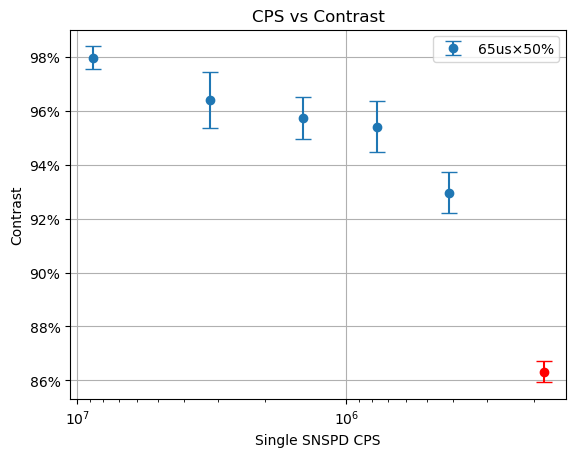

In [231]:
ref60_cps_df=pd.read_csv('65us_cps.csv')
ref60_cps_df['cps']*=1e3
ref60_cps_df['cps']/=(65/500*0.5)
broken_index=5
plt.errorbar(ref60_cps_df['cps'][:-1],ref60_cps_df['contrast'][:-1],yerr=ref60_cps_df['err'][:-1],fmt='o',capsize=6,label='65us×50%')
plt.errorbar(ref60_cps_df['cps'][broken_index],ref60_cps_df['contrast'][broken_index],yerr=ref60_cps_df['err'][broken_index],fmt='o',capsize=6,c='red')
## x轴反转
plt.legend()
plt.title('CPS vs Contrast')
plt.gca().invert_xaxis()
plt.xlabel('Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.grid()
plt.show()


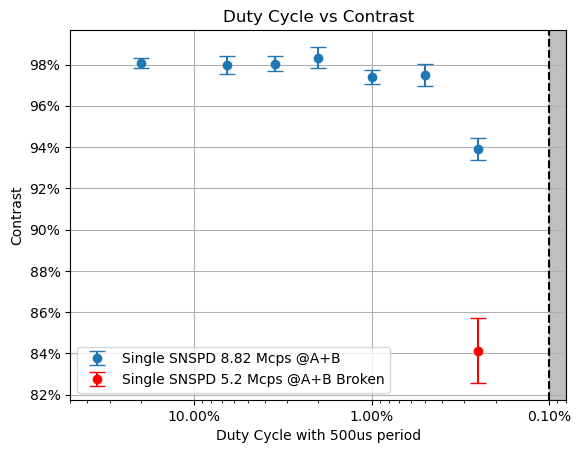

In [232]:
duty_cycle_df=pd.read_csv('dutyCycle.csv')
duty_cycle_df['cps']*=1e3
duty_cycle_df['dutyCycle']=duty_cycle_df['ref']/500/2
duty_cycle_df['cps']=duty_cycle_df['cps']/duty_cycle_df['dutyCycle']
duty_cycle_df['mean_cps']=duty_cycle_df['cps']
_cps_7M_index=(duty_cycle_df['mean_cps']>7e6)&(duty_cycle_df['contrast']>0.5)
_index_2_borken=1
mean_cps_7M=np.mean(duty_cycle_df['mean_cps'][_cps_7M_index])/1e6
plt.errorbar(duty_cycle_df['dutyCycle'][_cps_7M_index],duty_cycle_df['contrast'][_cps_7M_index],yerr=duty_cycle_df['err'][_cps_7M_index],fmt='o',capsize=6,label='Single SNSPD {:.2f} Mcps @A+B'.format(mean_cps_7M))
plt.errorbar(duty_cycle_df['dutyCycle'][_index_2_borken],duty_cycle_df['contrast'][_index_2_borken],yerr=duty_cycle_df['err'][_index_2_borken],fmt='o',capsize=6,c='red',label='Single SNSPD 5.2 Mcps @A+B Broken')
plt.axvline(0.001,color='k',linestyle='--')
## 灰色填充虚线右边
plt.axvspan(0.001,8e-4,color='gray',alpha=0.5)
plt.legend()
plt.title('Duty Cycle vs Contrast')
plt.gca().invert_xaxis()
plt.xlabel('Duty Cycle with 500us period')
plt.xscale('log')
plt.ylabel('Contrast')
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
plt.xlim(5e-1,8e-4)
plt.grid()
plt.show()


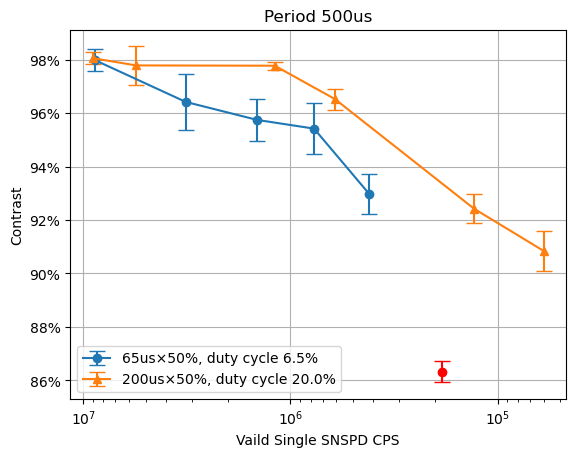

In [233]:
ref65_df=duty_cycle_df[duty_cycle_df['ref']==65]
ref200_df=duty_cycle_df[duty_cycle_df['ref']==200]
broken_index=ref65_df['contrast']<90
# 连线平滑处理
from scipy.interpolate import make_interp_spline

plt.errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o-',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2))
plt.errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
#三角形形状
plt.errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^-',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2))
## x轴反转
plt.legend()
plt.title('Period 500us')
plt.gca().invert_xaxis()
plt.xlabel('Vaild Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.grid()
plt.show()


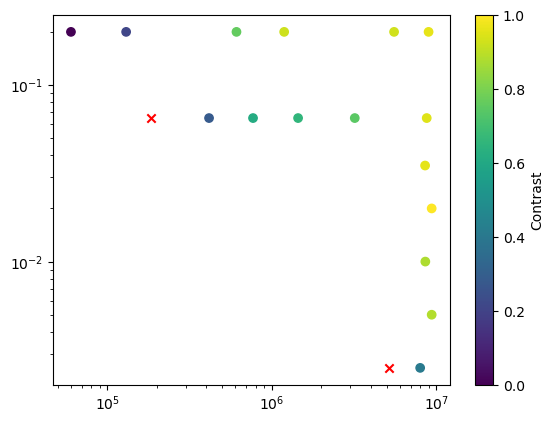

In [234]:
# 根据contrast绘制颜色散点图
_index_scat=duty_cycle_df['contrast']>90
plt.scatter(duty_cycle_df['mean_cps'][_index_scat], duty_cycle_df['dutyCycle'][_index_scat], c=duty_cycle_df['contrast'][_index_scat], cmap='viridis')
plt.scatter(duty_cycle_df['mean_cps'][~_index_scat][1:], duty_cycle_df['dutyCycle'][~_index_scat][1:], marker='x',color='red', label='Contrast < 90%')
plt.xscale('log')
plt.yscale('log')
# 添加颜色条
plt.colorbar(label='Contrast')

1. 当测量窗口的相位变化$\Delta\varphi_{window}=\sigma\sqrt{\tau}$与散粒噪声$\Delta\varphi_{shot}=(\frac{1}{\sqrt{2N\tau}})$持平时  
  $\Delta\varphi=(\frac{\sigma^2}{2N})^{1/4}$
2. 对比度变化为
  $\gamma=A\cos{\Delta\varphi}$

65us Fitted parameters: a=99.26, b=8.97802, sigma=113.97513
200us Fitted parameters: a=100.00, b=7.07935, sigma=70.86579


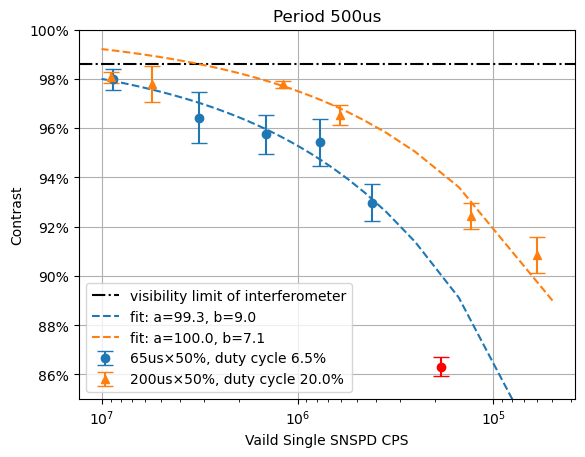

In [254]:
# 指数衰减拟合
from scipy.optimize import curve_fit
def cos_func(x,a,b):
    return a * np.cos(b*np.power(x,-1/4))

# 拟合数据
popt_65, pcov_65 = curve_fit(cos_func, ref65_df['cps'][1:], ref65_df['contrast'][1:], p0=(100, 1),sigma=ref65_df['err'][1:],)
popt_200, pcov_200 = curve_fit(cos_func, ref200_df['cps'][:-2], ref200_df['contrast'][:-2], p0=(100, 1),sigma=ref200_df['err'][:-2],)
x_fit = np.linspace(5e4, 1e7, 100)  
y_fit_65 = cos_func(x_fit, *popt_65)
y_fit_200 = cos_func(x_fit, *popt_200)
print('65us Fitted parameters: a={:.2f}, b={:.5f}, sigma={:.5f}'.format(*popt_65,popt_65[1]**2*1.414))
print('200us Fitted parameters: a={:.2f}, b={:.5f}, sigma={:.5f}'.format(*popt_200,popt_200[1]**2*1.414))

limit_line = plt.axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)

plt.plot(x_fit, y_fit_65, '--', label='fit: a={:.1f}, b={:.1f}'.format(*popt_65),color='C0')
plt.errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2),color='C0')
plt.errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
plt.plot(x_fit, y_fit_200, '--', label='fit: a={:.1f}, b={:.1f}'.format(*popt_200),color='C1')
plt.errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2),color='C1')

plt.xscale('log')
plt.title('Period 500us')
plt.gca().invert_xaxis()
plt.xlabel('Vaild Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
plt.legend()
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.ylim(85,100)
plt.grid()
plt.show()

65us Fitted parameters: a=8.23, sigma=95.69722
200us Fitted parameters: a=5.76, sigma=46.88042


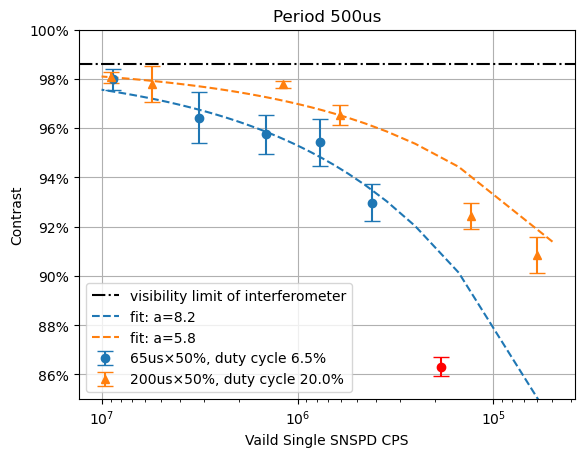

In [263]:
# 指数衰减拟合
from scipy.optimize import curve_fit
def cos_func(x,b):
    a=VIS_HIGHLINE
    return a * np.cos(b*np.power(x,-1/4))

# 拟合数据
popt_65, pcov_65 = curve_fit(cos_func, ref65_df['cps'][1:], ref65_df['contrast'][1:], p0=(1),sigma=ref65_df['err'][1:],)
popt_200, pcov_200 = curve_fit(cos_func, ref200_df['cps'][:-2], ref200_df['contrast'][:-2], p0=(1),sigma=ref200_df['err'][:-2],)
x_fit = np.linspace(5e4, 1e7, 100)  
y_fit_65 = cos_func(x_fit, *popt_65)
y_fit_200 = cos_func(x_fit, *popt_200)
print('65us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_65,popt_65[0]**2*1.414))
print('200us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_200,popt_200[0]**2*1.414))

limit_line = plt.axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)

plt.plot(x_fit, y_fit_65, '--', label='fit: a={:.1f}'.format(*popt_65),color='C0')
plt.errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2),color='C0')
plt.errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
plt.plot(x_fit, y_fit_200, '--', label='fit: a={:.1f}'.format(*popt_200),color='C1')
plt.errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2),color='C1')

plt.xscale('log')
plt.title('Period 500us')
plt.gca().invert_xaxis()
plt.xlabel('Vaild Single SNSPD CPS')
plt.xscale('log')
plt.ylabel('Contrast')
plt.legend()
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
plt.ylim(85,100)
plt.grid()
plt.show()

65us Fitted parameters: a=8.23, sigma=95.69722
200us Fitted parameters: a=5.76, sigma=46.88042


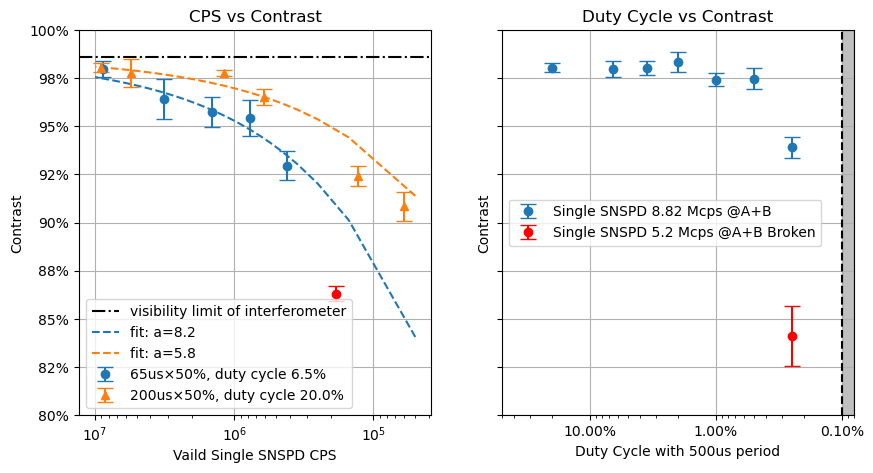

In [277]:
from scipy.optimize import curve_fit
def cos_func(x,b):
    a=VIS_HIGHLINE
    return a * np.cos(b*np.power(x,-1/4))

# 拟合数据
popt_65, pcov_65 = curve_fit(cos_func, ref65_df['cps'][1:], ref65_df['contrast'][1:], p0=(1),sigma=ref65_df['err'][1:],)
popt_200, pcov_200 = curve_fit(cos_func, ref200_df['cps'][:-2], ref200_df['contrast'][:-2], p0=(1),sigma=ref200_df['err'][:-2],)
x_fit = np.linspace(5e4, 1e7, 100)  
y_fit_65 = cos_func(x_fit, *popt_65)
y_fit_200 = cos_func(x_fit, *popt_200)
print('65us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_65,popt_65[0]**2*1.414))
print('200us Fitted parameters: a={:.2f}, sigma={:.5f}'.format(*popt_200,popt_200[0]**2*1.414))


fig,axs=plt.subplots(1,2,figsize=(10,5),sharey=True)
limit_line = axs[0].axhline(VIS_HIGHLINE,ls='-.',color='k', alpha=1,label='visibility limit of interferometer')
# limit_line_err = plt.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='k', alpha=0.2)
axs[0].plot(x_fit, y_fit_65, '--', label='fit: a={:.1f}'.format(*popt_65),color='C0')
axs[0].errorbar(ref65_df['cps'][1:],ref65_df['contrast'][1:],yerr=ref65_df['err'][1:],fmt='o',capsize=6,label='65us×50%, duty cycle {:.1%}'.format(65/500/2),color='C0')
axs[0].errorbar(ref65_df['cps'][broken_index],ref65_df['contrast'][broken_index],yerr=ref65_df['err'][broken_index],fmt='o',capsize=6,c='red')
axs[0].plot(x_fit, y_fit_200, '--', label='fit: a={:.1f}'.format(*popt_200),color='C1')
axs[0].errorbar(ref200_df['cps'],ref200_df['contrast'],yerr=ref200_df['err'],fmt='^',capsize=6,label='200us×50%, duty cycle {:.1%}'.format(200/500/2),color='C1')


axs[0].set_xscale('log')
axs[0].set_title('CPS vs Contrast')
axs[0].invert_xaxis()
axs[0].set_xlabel('Vaild Single SNSPD CPS')
axs[0].set_xscale('log')
axs[0].set_ylabel('Contrast')
axs[0].legend()
## y轴百分比
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
axs[0].set_ylim(80,100)
axs[0].grid()

duty_cycle_df=pd.read_csv('dutyCycle.csv')
duty_cycle_df['cps']*=1e3
duty_cycle_df['dutyCycle']=duty_cycle_df['ref']/500/2
duty_cycle_df['cps']=duty_cycle_df['cps']/duty_cycle_df['dutyCycle']
duty_cycle_df['mean_cps']=duty_cycle_df['cps']
_cps_7M_index=(duty_cycle_df['mean_cps']>7e6)&(duty_cycle_df['contrast']>0.5)
_index_2_borken=1
mean_cps_7M=np.mean(duty_cycle_df['mean_cps'][_cps_7M_index])/1e6
axs[1].errorbar(duty_cycle_df['dutyCycle'][_cps_7M_index],duty_cycle_df['contrast'][_cps_7M_index],yerr=duty_cycle_df['err'][_cps_7M_index],fmt='o',capsize=6,label='Single SNSPD {:.2f} Mcps @A+B'.format(mean_cps_7M))
axs[1].errorbar(duty_cycle_df['dutyCycle'][_index_2_borken],duty_cycle_df['contrast'][_index_2_borken],yerr=duty_cycle_df['err'][_index_2_borken],fmt='o',capsize=6,c='red',label='Single SNSPD 5.2 Mcps @A+B Broken')
axs[1].axvline(0.001,color='k',linestyle='--')
## 灰色填充虚线右边
axs[1].axvspan(0.001,8e-4,color='gray',alpha=0.5)
axs[1].legend()
axs[1].set_title('Duty Cycle vs Contrast')
axs[1].invert_xaxis()
axs[1].set_xlabel('Duty Cycle with 500us period')
axs[1].set_xscale('log')
axs[1].set_ylabel('Contrast')
## y轴百分比
axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
axs[1].set_xlim(5e-1,8e-4)
axs[1].grid()
plt.show()

